In [99]:
# 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("/content/drive/MyDrive/1학기 설계/6.6_dataset.csv")
print('Number of rows before = ',df.shape)

# SHA-256부분 & 빈도수가 0인 부분 제외
df = df.drop(['SHA-256'],axis=1) 
mask = df['push'or'mov'or'call'or'sub'or'jmp'or'add'or'cmp'or'test'or'lea'or'pop'or'FindFirstFile'or'SearchPathW'or'SetFilePointer'or'FindResourceEx'or'GetFileAttributesW'or'SetFileAttributesW'or'SetFilePointerEx'or'CryptEncrypt'or'CreateThread'or'FindResourceExW'].isin([0])
df = df[~mask]
print('Number of rows after = ',df.shape)
df.head()


Number of rows before =  (660, 22)
Number of rows after =  (601, 21)


,push,mov,call,sub,jmp,add,cmp,test,lea,pop,...,SearchPathW,SetFilePointer,FindResourceEx,GetFileAttributesW,SetFileAttributesW,SetFilePointerEx,CryptEncrypt,CreateThread,FindResourceExW,family
0,76103,101313,29344,4859,12795,33826,13694,18741,11052,19881,...,0,1,0,1,1,0,0,0,0,bengin
1,2317,5335,1574,381,674,3228,933,514,681,1479,...,0,21,26,5,0,0,0,0,26,bengin
2,25822,87411,23903,3535,7163,43742,8779,4333,7105,16319,...,0,0,0,0,0,0,0,0,0,bengin
3,76094,115296,46972,5925,12294,7575,20646,13479,21433,16816,...,1,1,1,1,0,0,0,1,1,bengin
4,25073,90674,23946,3605,7201,42950,8541,4224,7149,15881,...,0,0,0,0,0,0,0,0,0,bengin


bengin    0.735441
worm      0.143095
cerber    0.121464
Name: family, dtype: float64

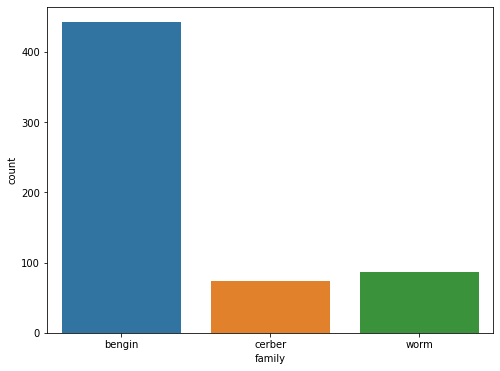

In [112]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(df['family'])
ax.set_xticklabels(['bengin','cerber', 'worm'])
df.family.value_counts(normalize=True) #cer와 정상 비율

In [114]:
# train/test 분리
from sklearn.model_selection import cross_val_score, train_test_split

X = df[df.columns.difference(['family'])]
Y = df['family']

print(X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3, random_state = 42)

# 전체 비율 
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# 실제데이터 비율 
print(Y_train.value_counts(normalize=True))
print(Y_test.value_counts(normalize=True)) 

(601, 20) (601,)
(420, 20) (420,) (181, 20) (181,)
bengin    0.723810
cerber    0.147619
worm      0.128571
Name: family, dtype: float64
bengin    0.762431
worm      0.176796
cerber    0.060773
Name: family, dtype: float64


In [115]:
# 표준화 
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,Normalizer

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)
print()
print(X_test)

[[ 1.31162264e+00 -1.11738407e-01 -2.44275849e-01 ...  1.72225686e-01
  -1.51762922e-01 -1.14616800e-01]
 [ 1.31162264e+00 -1.11738407e-01  2.01094057e+00 ... -3.03866883e-01
  -3.16426501e-01 -4.36979675e-01]
 [-2.93977793e-01 -8.43619271e-02  3.75004225e+00 ... -5.03106918e-01
  -3.99813826e-01 -5.53769700e-01]
 ...
 [-5.34817858e-01 -1.11738407e-01 -2.68343376e-01 ... -4.45557919e-01
  -3.92741737e-01 -5.19600916e-01]
 [-6.95377901e-01 -1.11738407e-01 -2.69234765e-01 ... -1.75027169e-01
   3.24283708e-01  3.29351339e-03]
 [-2.93977793e-01 -1.11738407e-01 -2.68343376e-01 ... -3.95013337e-01
  -3.61392325e-01 -3.92588263e-01]]

[[ 3.47918322 -0.09805017 -0.2482871  ... -0.43994845 -0.36498115
  -0.48291148]
 [-0.29397779 -0.11173841 -0.26834338 ... -0.44704191 -0.14775189
   0.0289201 ]
 [ 0.91022253 -0.11173841  1.98999291 ... -0.4523249  -0.37954754
  -0.49327415]
 ...
 [ 0.02714229 -0.11173841  0.99653888 ...  2.48994557  4.4676838
   3.19093301]
 [-0.6953779  -0.11173841 -0.269234

In [116]:
# Optuna 설치
!pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
# Classification 시각화
import itertools

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()

#SVC

In [118]:
from sklearn.svm import SVC


def objective(trial):
  svc_c = trial.suggest_float("C", 1e-10, 1e10, log=True)
  classifier_obj = SVC(C=svc_c, gamma="auto")
  
  score = cross_val_score(classifier_obj, X_train, Y_train, n_jobs=-1, cv=10)
  accuracy = score.mean()
  return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-16 15:15:32,422] A new study created in memory with name: no-name-1d41b28d-8a16-4c3e-bf6b-14fa2559b0c1
[I 2022-08-16 15:15:32,614] Trial 0 finished with value: 0.8690476190476192 and parameters: {'C': 2.013073304464817}. Best is trial 0 with value: 0.8690476190476192.
[I 2022-08-16 15:15:32,977] Trial 1 finished with value: 0.9023809523809524 and parameters: {'C': 647616.6641618067}. Best is trial 1 with value: 0.9023809523809524.
[I 2022-08-16 15:15:33,184] Trial 2 finished with value: 0.8595238095238095 and parameters: {'C': 0.5904719367620793}. Best is trial 1 with value: 0.9023809523809524.
[I 2022-08-16 15:15:33,394] Trial 3 finished with value: 0.7238095238095239 and parameters: {'C': 1.612065155981414e-10}. Best is trial 1 with value: 0.9023809523809524.
[I 2022-08-16 15:15:33,622] Trial 4 finished with value: 0.7238095238095239 and parameters: {'C': 0.013434872654204686}. Best is trial 1 with value: 0.9023809523809524.
[I 2022-08-16 15:15:33,900] Trial 5 finished wit

Number of finished trials: 100
Best trial:
  Value: 0.9357142857142857
  Params: 
    C: 3497.5736266167023


0.9337016574585635
              precision    recall  f1-score   support

      bengin       0.96      0.96      0.96       138
      cerber       0.64      0.82      0.72        11
        worm       0.93      0.88      0.90        32

    accuracy                           0.93       181
   macro avg       0.85      0.88      0.86       181
weighted avg       0.94      0.93      0.94       181

              precision    recall  f1-score   support

      bengin       0.96      0.96      0.96       138
      cerber       0.64      0.82      0.72        11
        worm       0.93      0.88      0.90        32

    accuracy                           0.93       181
   macro avg       0.85      0.88      0.86       181
weighted avg       0.94      0.93      0.94       181



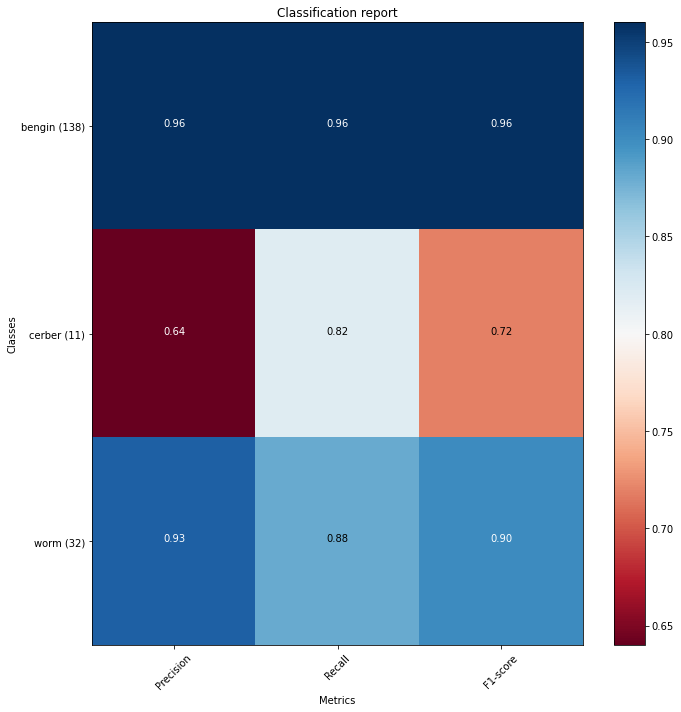

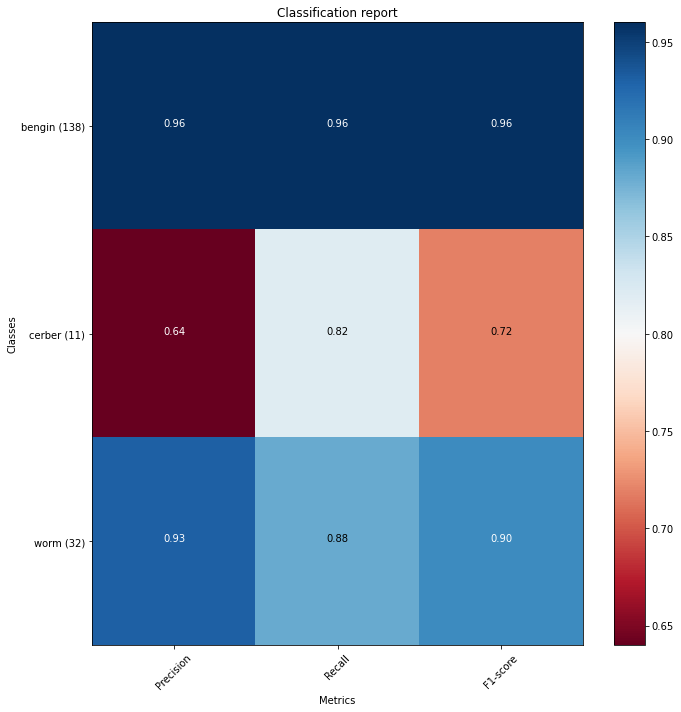

In [119]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


# 모델 학습

svc_c = study.best_params['C']
model = SVC(C=svc_c, gamma="auto",probability=True)
model.fit(X_train, Y_train)

# 모델 검증

scorer = make_scorer(accuracy_score) 
print(scorer(model, X_test, Y_test))

# 모델 예측

Y_pred = model.predict(X_test)
clf1 = classification_report(Y_test, Y_pred)
plot_classification_report(clf1)
print(clf1)

# Predict : 판단 결과 / Predict_proba : 각 클래스별 확률 값 ( 정상파일, 악성파일)
# 이진 분류 오류 ( 멀티클래스 문재로 오류 생김 ) 
# 참고 :  https://imdona.tistory.com/16
Y_pred_proba = model.predict_proba(X_test).argmax(axis=1)

Y_pred_proba = model.predict(X_test)
clf2 = classification_report(Y_test, Y_pred_proba)
plot_classification_report(clf2)
print(clf2)



# RandomForest

In [120]:
from sklearn.ensemble import RandomForestClassifier


def objective(trial):
  max_depth = trial.suggest_int("max_depth", 2, 32,log=True),
  n_estimators = trial.suggest_int('n_estimators', 10, 1000)
  # 다중클래스 오류 - class_weight 부분 모르겠다
  classifier_obj = RandomForestClassifier(max_depth = max_depth, n_estimators= n_estimators, class_weight= {'bengin':0.784, 'cerber': 0.00085, 'worm': 0.003} )
  
  score = cross_val_score(classifier_obj, X_train, Y_train, n_jobs=-1, cv=10)
  accuracy = score.mean()
  return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-16 15:18:49,845] A new study created in memory with name: no-name-d70fdf1f-dc64-45a0-aa3d-67725a363421
[W 2022-08-16 15:18:51,855] Trial 0 failed, because the objective function returned nan.
[W 2022-08-16 15:18:54,296] Trial 1 failed, because the objective function returned nan.
[W 2022-08-16 15:18:54,725] Trial 2 failed, because the objective function returned nan.
[W 2022-08-16 15:18:55,027] Trial 3 failed, because the objective function returned nan.
[W 2022-08-16 15:18:56,895] Trial 4 failed, because the objective function returned nan.
[W 2022-08-16 15:18:58,045] Trial 5 failed, because the objective function returned nan.
[W 2022-08-16 15:18:59,788] Trial 6 failed, because the objective function returned nan.
[W 2022-08-16 15:19:02,320] Trial 7 failed, because the objective function returned nan.
[W 2022-08-16 15:19:03,049] Trial 8 failed, because the objective function returned nan.
[W 2022-08-16 15:19:03,284] Trial 9 failed, because the objective function returned n

Number of finished trials: 100
Best trial:


ValueError: ignored

In [ ]:
# 모델 학습

rf_best = study.best_params
model = RandomForestClassifier(rf_best)
model.fit(X_train, Y_train)


# 모델 검증

scorer = make_scorer(accuracy_score) 
print(scorer(model, X_test, Y_test))


# 모델 예측
y_pred = model.predict(X_test)
clf1 =classification_report(Y_test, y_pred)
plot_classification_report(clf)
print(clf1)

# Predict : 판단 결과 / Predict_proba : 각 클래스별 확률 값 ( 정상파일, 악성파일)
# 이진 분류 오류 ( 멀티클래스 문재로 오류 생김 ) 
# 참고 :  https://imdona.tistory.com/16
Y_pred_proba = model.predict_proba(X_test).argmax(axis=1)

Y_pred_proba = model.predict(X_test)
clf2 = classification_report(Y_test, Y_pred_proba)
plot_classification_report(clf2)
print(clf2)